# Analyzing Images with ``for`` Loops and Functions

<img src="http://www.tate.org.uk/art/images/work/T/TW1/TW1328_9.jpg" alt="One of my favorite images" width="500">

In this notebook we will use liver images to 

1. Explore using ``for`` loops 
1. Work with numpy arrays 
1. Demonstrate writing user-defined functions

### Notebook magic

The cell below is an example of an IPython notebook magic. This is telling the Python kernel to draw [matplotlib](http://matplotlib.org/) plots in the notebook rather than trying to spawn a new Python window to draw on. There are many, many magics available as described [here](http://ipython.readthedocs.io/en/stable/interactive/magics.html?highlight=magics).

In [1]:
%matplotlib inline

In [14]:
%%bash

jupyter nbextension install widgetsnbextension --py --sys-prefix
jupyter nbextension enable widgetsnbextension --py --sys-prefix


Installing /opt/conda/lib/python3.5/site-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /opt/conda/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
Up to date: /opt/conda/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py --sys-prefix
    
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Imports

We now need to import a variety of packages for reading, displaying, and analyzing images in the notebook.

* [os](https://docs.python.org/3/library/os.html). This is an important Python library for working with the operating system. Prudent use of ``os`` can help make it easier to port your code to another computer or another user by avoiding hardwiring directory paths.
* [dicom](https://github.com/darcymason/pydicom): This is the PyDICOM package for reading in DICOM files.
* [numpy](http://www.numpy.org/): This is the standard array package for Python. Images will be represented using two or three dimensional arrays
* [scipy.stats](http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html): ``scipy`` is the package for scientific computing. It includes a subpackage ``stats`` that we will use for some basic statistical analysis.
* [skimage](http://scikit-image.org/): This i the scikit-image Package. We will use subpackages for displaying images (``io``) and creating rgb$\alpha$ images from the grayscale DICOM images.
* [ipywidgets](https://github.com/ipython/ipywidgets): This package provides functions for creating interactive widgets in the notebook.
* [IPython.display](http://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html): This package provides functionality for displaying in the notebook. In this case we important ``clear_output`` for clearing the ouptut of a cell.
* [matplotlib](http://matplotlib.org/): This is the standard plotting package for Python. There are alternatives, but matplotlib is definitely the msot common.
* [seaborn](https://web.stanford.edu/~mwaskom/software/seaborn/#): This is a package for common statistical display that is built on top of matplotlib. I don't quite know where it comes from, but ``sns`` is the common alias for the package.

In [2]:
import os
import time

import dicom
import numpy as np
from scipy import stats
import skimage.io as io
import skimage.color as color

from ipywidgets import interact, interactive, fixed
from IPython.display import clear_output
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns

## Set up a variable for the data directory

In [3]:
DATADIR = os.path.join(os.path.expanduser("~"),"DATA", "Images")

## Defining Functions

In this notebook we demonstrate and explore how to define our own functions and then use these functions in our programs.

## Define image functions we will use throughout this notebook

### One of the important purposes for defining functions is code reuse.

#### We define a functionality once and then use it multiple times. 

We are going to define two functions that we will use throughout this notebook.

* ``win_lev``: This is a function for transforming the CT HU range to the available range for display. [Here](http://dx.doi.org/10.1148/radiographics.12.4.1636042) is an article describing this.
* ``display_img``: This is a function that takes care of the niceties of displaying an image with ``matplotlib``, such as turning off grid lines

In [4]:
def win_lev(img, w, l, maxc=255):
    """
    Window (w) and level (l) data in img
    img: numpy array representing an image
    w: the window for the transformation
    l: the level for the transformation
    maxc: the maximum display color
    """

    m = maxc/(2.0*w)
    o = m*(l-w)
    return np.clip((m*img-o),0,maxc).astype(np.uint8)

In ``display_img`` we use matplotlib to draw a 2D image. ``cmap`` stands for "color map." The choice of [color maps](http://matplotlib.org/users/colormaps.html) is important for how we perceive the image information. In radiology images are almost always displayed with a gray-scale color map, although sometimes there are color overlays. It is considered important to use a "perceptually uniform colormap" although this is [frequently not the case](https://cdn.mprog.nl/dataviz/excerpts/w4/Borland_Rainbow_Color_Map.pdf).

In [5]:
def display_img(img, cmap="gray"):
    f, ax1 = plt.subplots(1)
    ax1.imshow(img, cmap=cmap)
    ax1.grid(False)
    ax1.yaxis.set_visible(False)
    ax1.xaxis.set_visible(False)
    return f, ax1

### Problem Set #1

Every function should have a [docstring](https://www.python.org/dev/peps/pep-0257/) describing what the function does, the nature of the arguments, and the value returned by the function. The docstring of a function is returned by [``help``](https://docs.python.org/3/library/functions.html#help) when the function is an argument to ``help``.

The docstring for a function is what the ``help`` function returns.

1. Write a docstring for ``display_img``. Use the ``help`` function to test your result. Is your docstring adequate?

## Finding Images

We here use two functions from the ``os`` package:

* [``os.path.join``](https://docs.python.org/3/library/os.path.html): This function creates an operating system appropriate path by joining names using the appropriate directory delimiter.
* [``os.listdir``](https://docs.python.org/3/library/os.html#os.listdir): this function returns the contents of a directory in a [list](https://docs.python.org/3/tutorial/datastructures.html#more-on-lists). 

We are using list comprehension to filter (select) our data. The topic of selecting data is explored in [this notebook](../../3-introducing_data_science/InClass/selecting_data_subsets.ipynb).

## Question

### What are the advantages of defining a variable that points to the directory where are images are located?

In [6]:
HCCDIR = os.path.join(DATADIR,"HCC")
files = os.listdir(HCCDIR)

original_imgs = [f for f in files if 'mask' not in f]
mask_imgs = [f for f in files if 'mask' in f]

print(original_imgs)
print("*"*42)
print(mask_imgs)

['neg_hepatic_phase.dcm', 'neg_hepatic_phase_b.dcm', 'neg_hepatic_phase_a.dcm', 'pos_hepatic_phase.dcm']
******************************************
['pos_hepatic_phase_mask.dcm', 'neg_hepatic_phase_mask.dcm']


## Image Browser

Here we define a function for browsing a 3D medical image. We browse the image by varying which axial slice we view. We can also change the window, level values of the display. ``view_volume`` will create a GUI for us to interact with the data. 

We are using the [``@interact``]() **decorator** [**TODO: NEED A GOOD REFERENCE FOR DECORATORS**]. Decorators are a way of creating new functions from existing functions. [See Chapter 11 in *Functional Python Programming*](http://proquest.safaribooksonline.com.ezproxy.lib.utah.edu/book/programming/python/9781784396992/functional-python-programming/ch11_html) Decorators are an **advanced** topic that we don't really need to worry about, but in this case are necessary for us making an interactive function in the notebook.


* ``IntSlider`` will create a slider with integer values that we can adjust dynamically.
* ``_view_slice`` is a function which is only visible within the function ``view_volume``. 
    * This is a result of how Python defines **namespaces**. In brief objects (variables, functions, etc) defined inside a function exist (are only visible) within that function. If you have time, you can learn more about **namespaces** [here](./functions_namespaces.ipynb).



In [8]:
def view_volume(img):
    @interact(sl=widgets.IntSlider(min=0, max=img.shape[0]-1, value=int(img.shape[0]/2)),
                 win=widgets.IntSlider(min=1, max=2000, value=1000),
                 level=widgets.IntSlider(min=-1024, max=2000, value=0))
    def _view_slice(sl=0,win=1000,level=0):
        display_img(win_lev(img[sl,:,:],win,level))

# Problem Set #2

1. Write a docstring for ``view_volume``
1. Explain how ``_view_slice`` can use  ``img``. **Hint:** think about the **namespace**
1. Use ``view_volume`` to count how many hypervascular (HCC) lesions are present in 'pos_hepatic_phase.dcm'.
    * For these images, a "hypervascular" lesion appears brigher than the surrounding liver.
    * **Hint:** you will need to use ``os.path``
    * **Hint:** You access the pixel data of the DICOM image with the **attribute** ``pixel_array``. (Remember dot notation!)

In [9]:
pos_img = dicom.read_file(os.path.join(HCCDIR,???))
view_volume(???)

SyntaxError: invalid syntax (<ipython-input-9-8dbabbb2b094>, line 1)

Masks (binary images where the pixels/voxels are 1 at the liver and 0 elsewhere) have been defined. This will be important for helping us analyze the liver properties.

In [7]:
img = dicom.read_file(os.path.join(HCCDIR,original_imgs[-1]))
mask = dicom.read_file(os.path.join(HCCDIR,mask_imgs[-1]))

## For loops and Images

In this course ``for`` loops will be our most common means of iterating over data and will be used extensively in Pandas. We will gain a little more familiarity with ``for`` loops by iterating over images. In our next examples, we illustrate how a for loop can iterate over the rows or columns of an image. 

Some important points that are illustrated in these functions:

1. We use the [``range``]() function to create an iterator that provides integers between the starting value inclusive (e.g. 0) and an ending value (e.g. ``img.shape[-1]/dx``)
1. We use the scikit-image ``color.gray2rgb`` to create an rgb$\alpha$ image. 
1. We use assignment with [slicing]() to set the alpha values in the appropriate portion of the image

* ``time.sleep`` makes the program *sleep* for the specified number of seconds (can be a floating point value, less than 1)

In [ ]:
def loop_x(img, dx=64, alpha=128):
    """
    """
    for i in range(0,int(img.shape[-1]/dx)):
        clear_output()
        print(i)
        t1 = color.gray2rgb(win_lev(img,200,0), alpha=True)
        t1[:, i*dx:i*dx+dx, 3] = 128
        f, ax1 = display_img(t1)
        plt.show()
        time.sleep(1)
        

### DICOM RescaleIntercept

* The DICOM image standard defines a ``RescaleIntercept`` value that is added to the stored pixel values to make the pixel values correspond to the original measured value (e.g. Hounsfield Units for CT images).

In [ ]:
loop_x(img.pixel_array[22,:,:]+img.RescaleIntercept)

## Problem Set #3

1. Finish/correct ``loop_y`` so that similar functionality as ``loop_x`` is acheived but now use ``dx`` as the increment value in the range function. You will need to adjust line 8 also. **Hint**: You will need to replace all the ``???`` instances with valid Python code.

In [ ]:
def loop_y(img, dx=64):
    """
    """
    for j in range(0,???, ???):
        clear_output()
        print(j)
        t1 = color.gray2rgb(win_lev(img,200,0), alpha=True)
        t1[???] = 128
        f, ax1 = display_img(t1)
        plt.show()
        time.sleep(1)        

In [ ]:
loop_y(img.pixel_array[22,:,:]+img.RescaleIntercept)

## Iterating over rows and columns

Showing that we can iterate over rows or columns is illustrative of looping but not very useful. In reality we will want to iterate over rows AND columns. We can do this with **nested** for loops that we will illustrate shortly. But first let's create a region-of-interest (ROI) browser.  In ``view_roi`` we define a square ROI of size dx by dx and move this ROI around in x, y, and z. The ROI is displayed by changing the $\alpha$ channel value. In addition to the image display, we plot a histogram of the Hounsfield Units (HU) in the ROI with the mean liver HU value indicated by a red line. We can mimic the task of the radiologist by moving the ROI around and looking for ROIs with substantially higher values than the liver mean.

In [8]:

def view_roi(img, mask, dx=64):
    """
    """
    mean_liver = img.flat[np.nonzero(mask.flat)].mean()

    @interact(dx=fixed(dx),
              sl=widgets.IntSlider(min=0, max=img.shape[0]-1, value=int(img.shape[0]/2)),
              i=widgets.IntSlider(min=0, max=img.shape[2]-dx, value=img.shape[2]/2, step=dx/4),
              j=widgets.IntSlider(min=0, max=img.shape[1]-dx, value=img.shape[1]/2, step=dx/4),
              win=widgets.IntSlider(min=1, max=2000, value=1000),
              level=widgets.IntSlider(min=-1024, max=2000, value=0))
    def _view_slice_roi(sl=0, dx=1, i=0, j=0, win=1000, level=0):
        s = img[sl,:,:]
        t1 = color.gray2rgb(win_lev(s,win,level), alpha=True)
        t1[j:j+dx,i:i+dx,3] = 128
        f,(ax1,ax2) = plt.subplots(1,2)
        f.set_size_inches(10,5)
        io.imshow(t1,ax=ax2)
        ax2.grid(False)
        ax2.yaxis.set_visible(False)
        ax2.xaxis.set_visible(False)
        sns.distplot(img[sl,j:j+dx,i:i+dx].flat,ax=ax1)
        ax1.axvline(x= mean_liver, color="red", linewidth=5, alpha=0.5)
        
        #sns.distplot(img[s1,j*dx:dx*(j+1),i*dx:dx*(i+1)])

### Synthetic Images

In the HCC directory are two images (``neg_hepatic_phase_a.dcm`` and ``neg_hepatic_phase_b.dcm`` with synthetic square HCCs superimposed on the liver. Select one of these to work with. 


In [9]:
liver_img = dicom.read_file(os.path.join(HCCDIR,'neg_hepatic_phase_a.dcm'))
liver_mask = dicom.read_file(os.path.join(HCCDIR,'neg_hepatic_phase_mask.dcm')).pixel_array

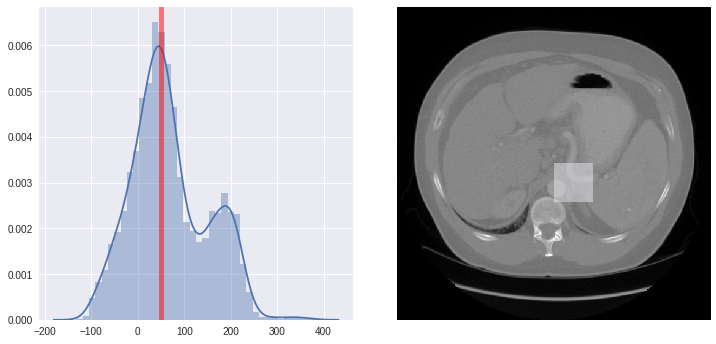

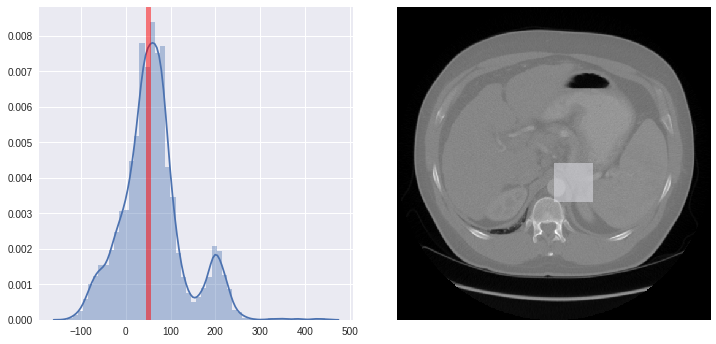

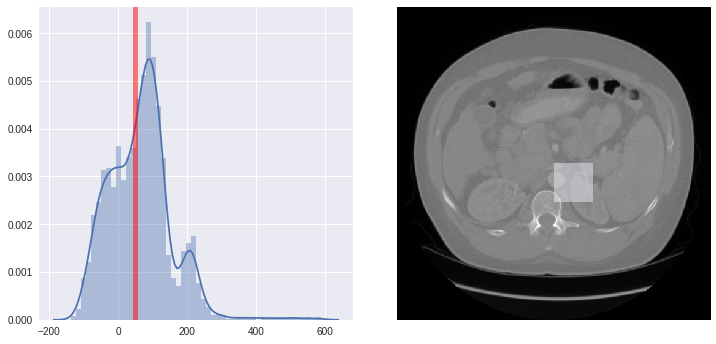

In [10]:
view_roi(liver_img.pixel_array, liver_mask, dx=64)

## Problem Set #4

In the functions below we use **nested for loops** to loop over the image and compute summary statistics (mean, standard error of the mean) for each ROI. We use the mask image to only compute values where the ROI overlaps with the liver (where the binary mask is 1). We then use the matplotlib ``errorbar`` method to plot the values. 

Here are snippets of the code that you might want to explore:

* The Numpy [``nonzero`` function](http://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html)
* The [``flat``](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flat.html) attribute of a numpy array.

### Comment: Creating Graphs is a Tedious Process and for the most part we will try to use high-level plotting functions whenever possible
#### Moral: Don't worry about things like ``subplots``, etc. at this time.

1. Modify/complete the functions below Vary the ROI size (dx) from 8 to 64 and compare the results. How would you go about defining an algorithm to detect the ROIs? Any intermediate steps you could imagine that would help?

In [ ]:
def get_liver_sub(img, mask, i, j, k, dx):
    inds = np.nonzero(mask[k:k+1, j:j+dx, i:i+dx])
    return img[k:k+1, j:j+dx,i:i+dx][inds]



def get_substats(img, mask, dx=64):
    data = []
    for k in range(0,img.shape[0]):
        for j in range(0, img.shape[1]-dx, int(dx/1)):
            for i in range(0, img.shape[2]-dx, int(dx/1)):
                d = get_liver_sub(img, mask, i, j, k, dx)
                if d.any():
                    data.append((i+j*img.shape[2]+k*img.shape[2]*img.shape[1], d))
                
    return data

def examine_rois(img, mask, dx=128):
    tmp_data = get_substats(img, mask, dx=dx)

    tt = [(t[0],np.mean(t[1]),stats.sem(t[1])) for t in tmp_data]
    f, ax1 = plt.subplots(1)
    f.set_size_inches(10,5)
    ax1.errorbar(x=range(len(tt)), y=[x[1] for x in tt], yerr=[x[2] for x in tt], fmt='o', markersize=5)
    ax1.axhline(y = img.flat[np.nonzero(mask.flat)].mean(), color="red", linewidth=5, alpha=0.5)
    ax1.set_ylabel("mean HU")
    ax1.set_xlabel("ROI #")

In [ ]:
examine_rois(liver_img.pixel_array, liver_mask, dx=8)

In [ ]:
examine_rois(liver_img.pixel_array, liver_mask, dx=16)

In [ ]:
examine_rois(liver_img.pixel_array, liver_mask, dx=32)

In [ ]:
examine_rois(liver_img.pixel_array, liver_mask, dx=64)

## Visualization Assessment

We used a default matplotlib scatter plot. What are some possible improvements?